### Introduction
With the prevalence of COVID-19 leading to extended closures and shutdowns of schools across the world, learning transitioned to mainly in the home. It has led to effects on student learning that has yet to be understood entirely. To examine one aspect, we are looking at the change in students' test scores pre-lockdowns and during lockdowns to better understand the impact remote learning had on students' ability to retain and apply knowledge on exams. We also want to observe if there has been an increase in the spread of student test scores, as some students' household learning will be less affected by the pandemic compared to others. To investigate if there has been an increase in the spread of student test scores, we will look at the standard deviation of test scores pre-lockdown and post-lockdown. We will perform hypothesis testing on mean test scores pre-lockdown and post-lockdown to see if there is a statistically significant difference in test scores.





### Preliminary Results

In [3]:
# library(cowplot)
# library(datateachr)
library(digest)
library(infer)
library(repr)
# library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(readxl)

In [4]:
url <- "https://raw.githubusercontent.com/dylanc9918/STAT_201_Project/main/COVID_data_csv.csv"

covid <- 
    read_csv(url)
head(covid)

Rows: 8400 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (18): studentID, school, gradelevel, gender, covidpos, householdincome, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


studentID,school,gradelevel,gender,covidpos,householdincome,freelunch,numcomputers,familysize,fathereduc,mothereduc,readingscore,writingscore,mathscore,readingscoreSL,writingscoreSL,mathscoreSL,timeperiod
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,6,1,1,59065,0,5,3,1,0,73,69,87,85,83,71,2
1,0,6,1,1,59065,0,5,3,1,0,63,73,57,78,75,58,4
1,0,6,1,1,59065,0,5,3,1,0,80,67,57,88,80,85,1
1,0,6,1,1,59065,0,5,3,1,0,69,56,74,70,48,87,3
1,0,6,1,1,59065,0,5,3,1,0,83,87,65,69,86,66,0
1,0,6,1,1,59065,0,5,3,1,0,62,37,63,82,78,85,5


`summarise()` has grouped output by 'studentID'. You can override using the
`.groups` argument.


studentID,timeperiod,meanscore
<dbl>,<int>,<dbl>
1,0,79.22222
1,1,73.44444
2,0,73.11111
2,1,64.44444
3,0,82.55556
3,1,66.88889


timeperiod,mean,sd
<int>,<dbl>,<dbl>
0,75.70167,7.252901
1,67.69460,7.171113


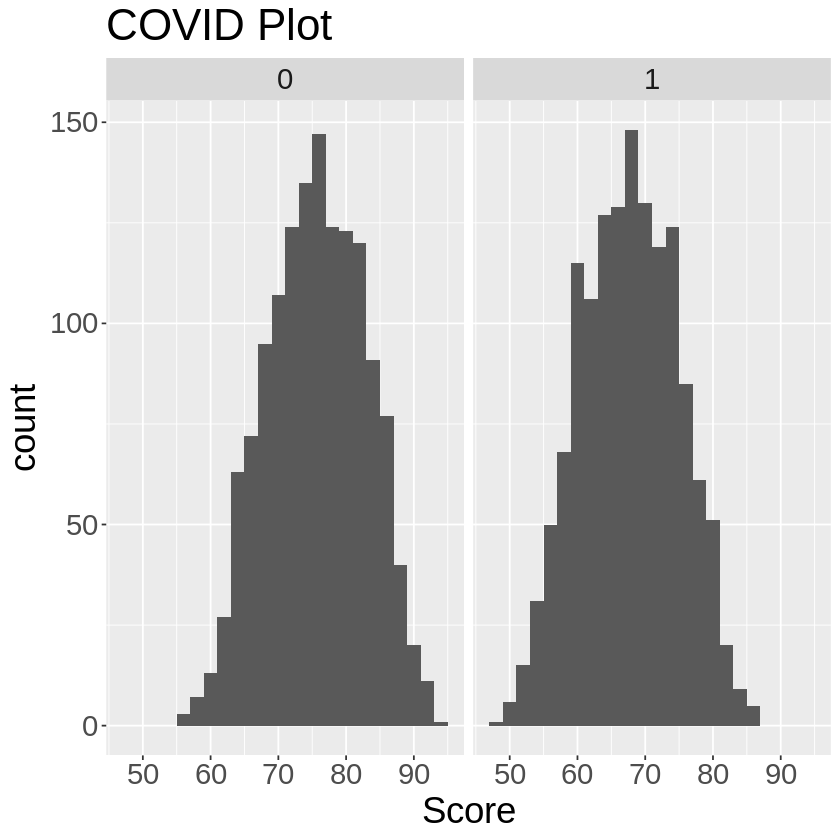

In [5]:
covid_n <- covid %>%
mutate(timeperiod = as.integer(timeperiod / 3))%>%#changing timeperiod to either 0 or !, 0 represents before COVID and 1 represents after COVID
select("studentID", "readingscoreSL", "writingscoreSL", "mathscoreSL", "timeperiod")%>%#we only want these 5 column
mutate(scoresumSL = (readingscoreSL + writingscoreSL + mathscoreSL)/3)%>%
#creating a new column that contains students' average of all score of the provincial level test
group_by(studentID, timeperiod)%>%
summarize(meanscore = mean(scoresumSL))# mean of each test
head(covid_n)

covid_summarize <- covid_n%>%
group_by(timeperiod)%>%
summarize(mean = mean(meanscore),
         sd = sd(meanscore))# mean of all students' score before and after covid
covid_summarize


covid_samp_dist_plot <- 
    covid_n %>% 
    ggplot() + 
    geom_histogram(aes(x = meanscore), binwidth = 2) +
    facet_wrap(~ timeperiod	) + 
    xlab("Score")+
    ggtitle("COVID Plot")+
    theme(text = element_text(size = 22))
covid_samp_dist_plot


### Methods: Plan

In [6]:
count_students = nrow(covid_n)/2
count_students

[1] 1400

Our point estimate is the mean score difference of students in reading, writing, and maths courses in the pre and post-lockdown. We could obtain it by doing the two-sample z-test, assuming the two samples are independent with no more than 10% of the population and are chosen randomly. We choose the alpha equals 0.05 as a significant level since it uses the most in statistical research. And we expect to see a higher mean score of students in all three courses in the prep than post-lockdown. Our hypothesis is first supported by the research of 5.4 million U.S. primary students' performance, showing a decrease in average reading and maths scores in 0.20-0.27 and 0.09-0.18 standard deviation (S.D.s) respectively from 2019 to 2021 (Brown university, 2022). Plus, the research between face-to-face and virtual learning also shows that the student's performance score decreases from 76.0 to 41.3 when switching to remote learning. (Arabian Gulf University,2021). 
We will also create a 95% confidence interval, following with formula

(x1 - x2)  z * sqrt(s1^2/n1 + s2^2/n2)

where: 

- x1, x2 :x1 and x2 is the pre and post-lockdown sample mean score, respectively 
- Z: z score based on the confidence level 95%
- s1, s2 : s1 and s2 is the pre and post-lockdown sample, respectively
- n1 and n2: sample size of pre and post-lockdown sample, respectively. 

The benefits of this report are that we have a relatively large sample size to work with 1400 students in total, each with test scores for pre and post-lockdown,  satisfying the assumption to conduct the two-sample z-test and increasing confidence in estimating our population's mean and standard deviation. Plus, the tests are standardised across all students for all schools as every school takes the same state test, which will control for any differences between tests at different schools. Our current plots and summaries are a good start to visualising our distribution and mean for our two categories, but this is insufficient for determining if our findings are significant. 
We input the seed() function at the coding section's first row to ensure the data is reproducible, leading to sample variability. 


### References
- BOLLARD, D.Y.L.A.N. (no date) COVID-19 Effect on Grades. Available at: https://www.kaggle.com/datasets/dylanbollard/covid19-effect-on-grades-constructed-dataset?resource=download. 
- Kuhfeld, M., Soland, J. and Lewis, K. (2022) COVID-19 Effect on Grades [Preprint]. Available at: https://doi.org/Soland, J., Lewis, K., & Kuhfeld, M. (2022). (rep.). Test Score Patterns Across Three COVID-19-impacted School Years (Vol. 29). Portland, OR. . 
- Al Shaibani, T. et al. (2021) “Impact of COVID-19 pandemic on students’ performance in a problem-based learning system: comparative study between face-to-face-and virtual learning,” 9. Available at: https://doi.org/file:///Users/apple/Downloads/Impact_of_COVID-19_pandemic_on_students_performan.pdf. 
